In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel
%matplotlib inline
from matplotlib.path import Path
from matplotlib.figure import Figure
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.cm as cm
#from IPython.core.display import display
import matplotlib.patches as patches
#import math
import numpy as np
#from numpy import percentile
#from numpy.random import seed
import os
#from sklearn.preprocessing import StandardScaler
import datetime as dt
import time
#import re
import pyodbc
import sqlalchemy as sal
from sklearn.preprocessing import normalize 
from sqlalchemy import create_engine
import pandas as pd
# from scipy.stats import bartlett
# from scipy.stats import boxcox
# from sklearn.preprocessing import normalize 
# from scipy.stats import jarque_bera
# from scipy.stats import levene
# from scipy.stats import normaltest
# import scipy.stats as stats
# from scipy.stats.mstats import winsorize
# from scipy.stats import zscore
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import DBSCAN
# from sklearn.manifold import TSNE
# from sklearn.metrics import silhouette_score #
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics.pairwise import pairwise_distances
# from sklearn.metrics import precision_recall_curve
# from sklearn import preprocessing as pp
# from sklearn.model_selection import train_test_split 
# from sklearn.metrics import precision_recall_curve, average_precision_score
# from sklearn.metrics import roc_curve, auc, roc_auc_score
# import xlsxwriter
# from sklearn.cluster import KMeans
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, \
#     adjusted_mutual_info_score, adjusted_rand_score
# from sklearn.metrics import silhouette_samples,  silhouette_score
# from sklearn.metrics.cluster import contingency_matrix
import statsmodels.api as sm
from statsmodels.tsa import stattools

In [3]:
import sqlalchemy as sal
from sqlalchemy import create_engine
import pyodbc 

In [4]:
engine = sal.create_engine('mssql+pyodbc://5CD0134YG4/hcad2?driver=SQL Server?Trusted_Connection=yes')
conn = engine.connect()

# Exercise A

## 1. How many orders were completed in 2018? (Note: We operate in US/Eastern timezone)

In [5]:
query1 = '''
SELECT 
count(ordered_at_utc)
FROM [jiff].[dbo].[orders]
WHERE ordered_at_utc >= '2018-01-01' and ordered_at_utc <= '2018-12-31'
'''	

In [6]:
df1 = pd.read_sql_query(query0, conn)
df1

NameError: name 'query0' is not defined

## 2. How many orders were completed in 2018 containing at least 10 units?

In [ ]:
query2 = '''
SELECT 
--count([jiff].[dbo].[line_items].[order_number])

[jiff].[dbo].[line_items].[line_item_number] , [jiff].[dbo].[line_items].[order_number], [jiff].[dbo].[line_items].[units_sold], 
[jiff].[dbo].[line_items].[product_id]
      
FROM [jiff].[dbo].[orders]
Left Join  [jiff].[dbo].[line_items] ON [jiff].[dbo].[line_items].order_number = jiff.dbo.orders.order_number

WHERE ordered_at_utc >= '2018-01-01' and ordered_at_utc <= '2018-12-31'
AND
[jiff].[dbo].[line_items].[units_sold] >= 10

'''	

In [ ]:
df2 = pd.read_sql_query(query2, conn)
df2.shape[0]

## 3. How many customers have ever purchased a medium sized sweater with a discount?

In [ ]:
query3 = '''
SELECT 
O.[order_number], O.[ordered_at_utc], O.[customer_uuid], O.[discount],O.[order_number],
L.[line_item_number] , L.[order_number], L.[units_sold], L.[product_id],
P.[model_number], P.[description], P.[size], P.[color], P.[selling_price], P.[supplier_cost]
    
FROM [jiff].[dbo].[orders] AS O
Left Join  [jiff].[dbo].[line_items] AS L ON O.order_number = L.order_number
Left Join  [jiff].[dbo].[products] AS P ON L.[product_id] = P.[product_id]
WHERE O.discount >0 AND P.size = 'M'

'''	

In [ ]:
df3 = pd.read_sql_query(query3, conn)
df3.shape[0]

## 4. How profitable was our most profitable month? (Profit = Revenue - Cost)

In [ ]:
query4 = '''
SELECT 
O.[order_number], O.[ordered_at_utc], O.[customer_uuid], O.[discount],O.[order_number],
L.[line_item_number] , L.[order_number], L.[units_sold], L.[product_id],
P.[model_number], P.[description], P.[size], P.[color], P.[selling_price], P.[supplier_cost]
, L.[units_sold] * 		
            ((P.[selling_price]* (1 - O.[discount])) -  P.[supplier_cost] ) AS profit

FROM [jiff].[dbo].[orders] AS O
Left Join  [jiff].[dbo].[line_items] AS L ON O.order_number = L.order_number
Left Join  [jiff].[dbo].[products] AS P ON L.[product_id] = P.[product_id]
ORDER BY profit Desc
'''	

In [ ]:
df4 = pd.read_sql_query(query4, conn)
df4['ordered_at_utc'][0]

# Exercise B

## I will use time series analysis here and since the process is time consuming I will focus on a subset of the data

In [18]:
# Import data
import_path = 'C:\\dev_code\\jiffy'
file_name = import_path+"\\"+ "jiff_data.csv" 
df50 = pd.read_csv(file_name)
df50.shape

(266766, 16)

In [19]:
df50.head(2)

,order_number,ordered_at_utc,customer_uuid,discount,order_number.1,line_item_number,order_number.2,units_sold,product_id,model_number,description,size,color,selling_price,supplier_cost,profit
0,207792165,02/15/2019,4510467249342,0.12,207792165,260583422.0,207792165.0,1182.0,383372.0,T5000,Cotton T-shirt,S,WHITE,4.00,1.64,2222.160
1,324313206,11/13/2019,2637960371568,0.10,324313206,404783331.0,324313206.0,1006.0,383386.0,T5000,Cotton T-shirt,L,WHITE,3.74,1.55,1826.896


In [20]:
df50.dtypes

order_number          int64
ordered_at_utc       object
customer_uuid         int64
discount            float64
order_number.1        int64
line_item_number    float64
order_number.2      float64
units_sold          float64
product_id          float64
model_number         object
description          object
size                 object
color                object
selling_price       float64
supplier_cost       float64
profit              float64
dtype: object

In [30]:
df50['ordered_at_utc'] =  pd.to_datetime(df50['ordered_at_utc'])
df50.index = df50['ordered_at_utc']
df50 = df50.sort_index()

In [46]:
# df5 = df50[df50['ordered_at_utc'] >= '11/30/2019']
# df5.shape

In [31]:
df5 = df50.copy()
df5.head(2)

,order_number,ordered_at_utc,customer_uuid,discount,order_number.1,line_item_number,order_number.2,units_sold,product_id,model_number,description,size,color,selling_price,supplier_cost,profit
ordered_at_utc,,,,,,,,,,,,,,,,
2016-12-13,38936699,2016-12-13,6079304893969,0.02,38936699,37805636.0,38936699.0,13.0,384233.0,T5000,Cotton T-shirt,XL,BLACK,5.43,1.95,43.8282
2016-12-13,38947450,2016-12-13,2731086670992,0.00,38947450,37825124.0,38947450.0,8.0,384240.0,T5000,Cotton T-shirt,2XL,BLACK,8.58,3.42,41.2800


In [32]:
# Assume numbers of nulls are small hence can drop them
df5.isna().sum()

order_number           0
ordered_at_utc         0
customer_uuid          0
discount               0
order_number.1         0
line_item_number    4476
order_number.2      4476
units_sold          4476
product_id          4476
model_number        4476
description         4476
size                4476
color               4476
selling_price       4476
supplier_cost       4476
profit              4476
dtype: int64

In [33]:
# Drop all null rows
df6 = df5.dropna()
df5.shape, df6.shape

((266766, 16), (262290, 16))

In [34]:
# Measure the revenue
df6['revenue'] = df6['selling_price'] *  df6['units_sold'] * (1-df6['discount'])

<ipython-input-34-c4e89de12ab1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['revenue'] = df6['selling_price'] *  df6['units_sold'] * (1-df6['discount'])


In [35]:
df6.head(2)

,order_number,ordered_at_utc,customer_uuid,discount,order_number.1,line_item_number,order_number.2,units_sold,product_id,model_number,description,size,color,selling_price,supplier_cost,profit,revenue
ordered_at_utc,,,,,,,,,,,,,,,,,
2016-12-13,38936699,2016-12-13,6079304893969,0.02,38936699,37805636.0,38936699.0,13.0,384233.0,T5000,Cotton T-shirt,XL,BLACK,5.43,1.95,43.8282,69.1782
2016-12-13,38947450,2016-12-13,2731086670992,0.00,38947450,37825124.0,38947450.0,8.0,384240.0,T5000,Cotton T-shirt,2XL,BLACK,8.58,3.42,41.2800,68.6400


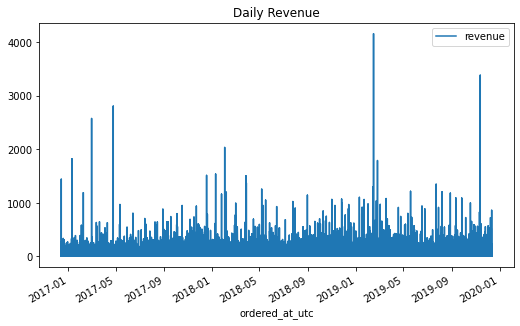

In [36]:
# Inspect the data
df6.index = pd.to_datetime(df6.ordered_at_utc)
df6.plot(y='revenue', figsize=(8.5, 5))
plt.title('Daily Revenue')
plt.show()

Text(0.5, 1.0, 'First-order (30 days) differences of Daily Revenue')

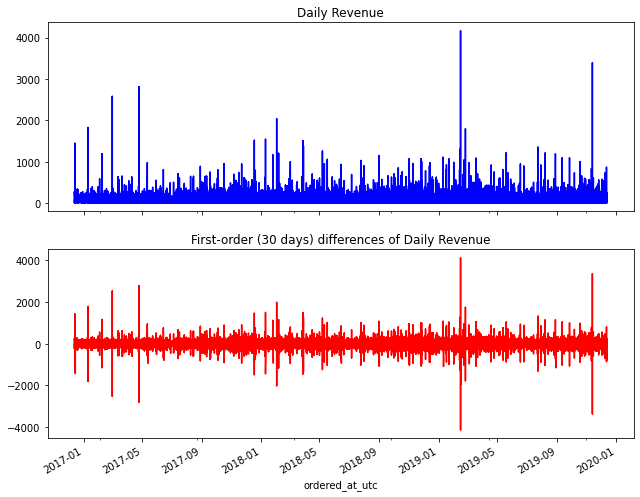

In [37]:
#Let us plot the original time series and first-order (30 days) differences
first_order_diff = df6['revenue'].diff(30)

fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(10.5, 8.5)
df6['revenue'].plot(ax=ax[0], color='b')
ax[0].set_title('Daily Revenue')
first_order_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-order (30 days) differences of Daily Revenue')

### A 30 days difference in revenue shows a sustaintable flat base. The remaining variations can be divided in two groups, those recurring and the outliers. 

In [38]:
## Let us obtain the confidence intervls, Ljung-Box Q-statistics and p-values
acf_forec, confint_forec, qstat_forec, pvalues_forec = stattools.acf(df6['revenue'],
                                                                 unbiased=True,
                                                                 nlags=35,
                                                                 qstat=True,
                                                                 alpha=0.05)

<ipython-input-38-b8ee36c1ed74>:2: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  acf_forec, confint_forec, qstat_forec, pvalues_forec = stattools.acf(df6['revenue'],
c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [39]:
# Let us check if at confidence level 95% (alpha=0.05) if the null hypothesis is rejected at any of the lags
alpha = 0.05
for l, p_val in enumerate(pvalues_forec):
    if p_val > alpha:
        print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
    else:
        print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))

Null hypothesis is rejected at lag = 0 for p-val = 6.584219234623419e-41
Null hypothesis is rejected at lag = 1 for p-val = 1.727493323812227e-168
Null hypothesis is rejected at lag = 2 for p-val = 3.985837173861516e-233
Null hypothesis is rejected at lag = 3 for p-val = 3.300670535289599e-303
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
Null hypothesis is rejected at lag = 10 for p-val = 0.0
Null hypothesis is rejected at lag = 11 for p-val = 0.0
Null hypothesis is rejected at lag = 12 for p-val = 0.0
Null hypothesis is rejected at lag = 13 for p-val = 0.0
Null hypothesis is rejected at lag = 14 for p-val = 0.0
Null hypothesis is rejected at lag = 15 for p-val = 0.0
Null hypothesis is rejected at lag = 16

### For these p<=.05 we can conclude that data does not have unique roots and time series is Stationary

### If p-value < 0.051: We can reject the null hypothesis assuming a 5% chance of making a mistake. So we can assume that our values are showing dependence on each other.
### If p-value > 0.051: We don't have enough statistical evidence to reject the null hypothesis. So we can not assume that our values are dependent. This could mean that our values are dependent anyway or it can mean that our values are independent. But we are not proving any specific possibility, what our test actually said is that we can not assert the dependence of the values, neither can we assert the independence of the values.

# Which of AR, MA or ARMA should we use?

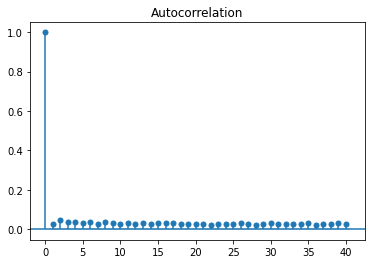

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
y = df6.revenue
plot_acf(y, lags=40)
fig.set_size_inches(10.5, 8.5)
plt.show()

### Try Partial Autocorrelation Function (PACF), which takes the correlation of time series with a lagged version of itself. Each bar represents the correlation with another lag. So the PACF at 1 is the correlation of initial series with itself, lagged by 1. Hence, for these kinds of plots, 0 will always return 1, because the time series perfectly correlates with itself.

c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


Text(0.5, 1.0, 'Yr Foreclosure Harris County, PACF')

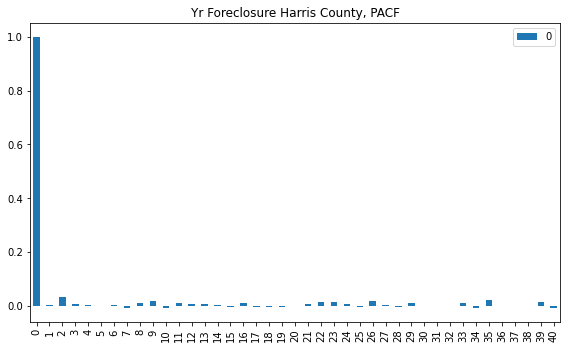

In [17]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df6.revenue))
x_acf.plot(kind='bar', figsize=(9.5, 5.5))
plt.title("Yr Foreclosure Harris County, PACF")

## Try Autoregressive Integrated Moving Average (ARMA), allowing us to add two additional kinds of terms — autoregressions and moving averages — to our specifications. Both autoregressive and moving-average models generally apply to stationary processes. 

### We are building a series of models to evaluate, and each will have slightly different parameters for the ARIMA. 
### Note that the parameters are passed in (p, d, q) order, corresponding to the AR, I, and MA portions, respectively.
### The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

In [41]:
# To illustrate the idea of moving average we compute monthly moving average taking
# a window of 12 months.
df6['revenue_moving_avg'] = df6['revenue'].rolling(30).mean()

<ipython-input-41-25d9a4f4c252>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['revenue_moving_avg'] = df6['revenue'].rolling(30).mean()


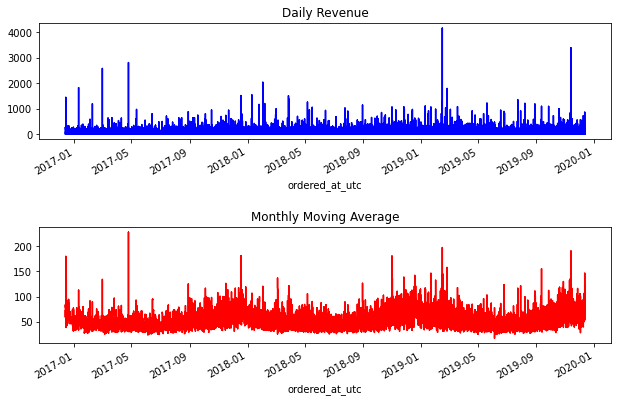

In [42]:
fig = plt.figure(figsize=(8.5, 5.5))
ax = fig.add_subplot(2,1,1)
df6['revenue'].plot(ax=ax, color='b')
ax.set_title('Daily Revenue')
ax = fig.add_subplot(2,1,2)
df6['revenue_moving_avg'].plot(ax=ax, color='r')
ax.set_title('Monthly Moving Average')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

In [43]:
#Calculate the moving averages using 'rolling' and 'mean' functions
MA2 = df6['revenue'].rolling(window=30).mean()
TwoXMA2 = MA2.rolling(window=2).mean()

MA3 = df6['revenue'].rolling(window=60).mean()
ThreeXMA3 = MA3.rolling(window=3).mean()

MA4 = df6['revenue'].rolling(window=90).mean()
TwoXMA4 = MA4.rolling(window=2).mean()

In [44]:
#Let's remove NaN from the above variables
MA2 = MA2[~pd.isnull(MA2)]
TwoXMA2 = TwoXMA2[~pd.isnull(TwoXMA2)]

MA3 = MA3[~pd.isnull(MA3)]
ThreeXMA3 = ThreeXMA3[~pd.isnull(ThreeXMA3)]

MA4 = MA4[~pd.isnull(MA4)]
TwoXMA4 = TwoXMA4[~pd.isnull(TwoXMA4)]

Text(0.5, 1.0, '90 days  MA')

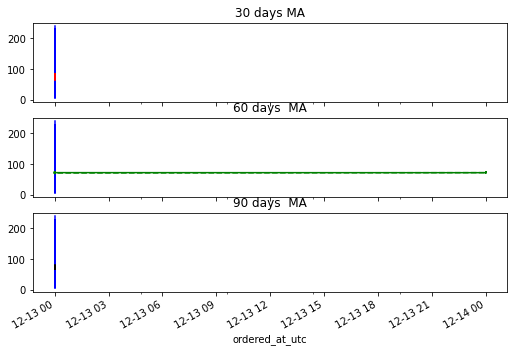

In [45]:

f, axarr = plt.subplots(3, sharex=True)
f.set_size_inches(8.5, 5.5)

df6['revenue'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0])
MA2.iloc[:45].plot(color='r', linestyle = '-', ax=axarr[0])
TwoXMA2.iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0])
axarr[0].set_title('30 days MA')

df6['revenue'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1])
MA4.iloc[:45].plot(color='g', linestyle = '-', ax=axarr[1])
TwoXMA4.iloc[:45].plot(color='g', linestyle = '--', ax=axarr[1])
axarr[1].set_title('60 days  MA')

df6['revenue'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[2])
MA3.iloc[:45].plot(color='k', linestyle = '-', ax=axarr[2])
ThreeXMA3.iloc[:45].plot(color='k', linestyle = '--', ax=axarr[2])
axarr[2].set_title('90 days  MA')

## Building ARIMA models

### Here we build a series of models to evaluate, and each will have slightly different parameters for the ARIMA. Note that the parameters are passed in (p, d, q) order, corresponding to the AR, I, and MA portions, respectively. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
model1 = ARIMA(df6.revenue, order=(1,1,1))
model1_fit = model1.fit()
print(model1_fit.summary())
print('Residuals Description')
#print(model1_fit.resid.describe())

c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [25]:
model2 = ARIMA(df6.revenue, order=(2,0,2))
model2_fit = model2.fit()
print(model1_fit.summary())
print('Residuals Description')
#print(model1_fit.resid.describe())

c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [26]:
model3 = ARIMA(df6.revenue, order=(3,0,3))
model3_fit = model3.fit()
print(model3_fit.summary())
print('Residuals Description')
#print(model3_fit.resid.describe())

c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [27]:
from statsmodels.tsa.arima_model import ARIMA
model4 = ARIMA(df6.revenue, order=(4,1,4))
model4_fit = model4.fit(disp=0)
print(model4_fit.summary())
print('Residuals Description')
print(model4_fit.resid.describe())

c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [28]:
from statsmodels.tsa.arima_model import ARIMA
model5 = ARIMA(df6.revenue, order=(1,1,1))
model5_fit = model5.fit(disp=0)
print(model5_fit.summary())
print('Residuals Description')
print(model5_fit.resid.describe())

c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\dev_code\cnp3\cnp_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

## How do these models comapre to each other

### One of the easiest ways to compare time series models is with something called the Akaike information criterion (AIC). The AIC is a measure of the degree of information contained in the model. Once you've identified the model with the lowest AIC, you'll compare that model to other models using the probability of information loss. You can find the probability that another model minimizes information loss using the following calculation:

𝑒𝑥𝑝((𝐴𝐼𝐶𝑚𝑖𝑛−𝐴𝐼𝐶𝑥)/2)


In [29]:
aic_lst = [model1_fit.aic, model2_fit.aic, model3_fit.aic, model4_fit.aic, model5_fit.aic]
Min_aic = min(aic_lst)

In [30]:
aic_lst

[147525.4975238273,
 147547.7592290601,
 147551.73359842744,
 147513.7375453174,
 147525.4975238273]

In [31]:
# Best model = Min AIC
min(aic_lst)

147513.7375453174

In [32]:
import math
# Check other AIC compared to best one
for i in aic_lst:
    print(math.exp((Min_aic-i)/2))

0.0027948153052840038
4.095295486603568e-08
5.613864165192689e-09
1.0
0.0027948153052840038


## Conclusion
ARIMA(20,1,1) performs best compared to other models. This also makes sense given the decay patterns we observed from ACF and PACF graphs. 

In [51]:
from itertools import product
from tqdm import tqdm_notebook

In [59]:
df7 = df6[df6['ordered_at_utc'] >= '09/30/2019']
df7.shape

(4866, 16)

In [56]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [54]:

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df7.revenue, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [57]:
result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

<ipython-input-54-8431db4c5da6>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/625 [00:00<?, ?it/s]

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements